# Precipitation Nowcasting using Neural Networks

In this exercise, you are going to build a set of deep learning models on a real world task using PyTorch. PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with PyTorch ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- Two-Dimentional Convolution Neural Network (2D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed PyTorch with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours). 

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfal in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

In [8]:
!nvidia-smi

Fri Mar 25 06:23:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# For summarizing and visualizing models
!pip install torchinfo
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=a4db64e319bcf7cfd14b40b05308e0baa02b54bf26a2e761b4d763f15e29f37e
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

In [1]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 69.9 MB/s 
     |████████████████████████████████| 144 kB 43.8 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=94cdb3034868258c2526eb76dda6dd44f819d90cb379cf0c16cf344c2586de15
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [3]:
!wandb login

wandb: Currently logged in as: grniss (use `wandb login --relogin` to force relogin)


In [9]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

torch.__version__ # 1.10.0+cu111

'1.10.0+cu111'

## Loading the data
Get the data set by going [here](https://drive.google.com/file/d/1NWR22fVVE0tO2Q5EbaPPrRKPhUem-jbw/view?usp=sharing) and click add to drive.

In [12]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [13]:
!tar -xvf '/content/gdrive/My Drive/nowcastingHWdataset.tar.gz'

dataset/features-m10.pk
dataset/features-m6.pk
dataset/features-m7.pk
dataset/features-m8.pk
dataset/features-m9.pk
dataset/labels-m10.pk
dataset/labels-m6.pk
dataset/labels-m7.pk
dataset/labels-m8.pk
dataset/labels-m9.pk


# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [14]:
def read_data(months, data_dir='dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)
        
        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [15]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


**features** 
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries 

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

# Three-Layer Feedforward Neural Networks

In [16]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_test_ff = x_test.reshape((-1, 5*5*3))
    y_test_ff = y_test.reshape((-1, 1))

    return x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)
(558575, 75) (558575, 1)


### TODO#1

Explain each line of code in the function preprocess_for_ff()

**Ans:** 

Reshape input-data(X) of each dataset into 2 dimension which 
- dim0: combine 5 time-steps of all entries as **5*no of entries** time-steps
- dim1: convert 5 * 5 * 3 inputs into 1-dimensions which the each 25 index is determine 5x5 grid of each channel respectively. 

And reshape each output-data(y) of each dataset to be corresponding to dim0 of train data which
- dim0: combine 5-time-steps of all entries like train data

## Dataset

To prepare a DataLoader in order to feed data into the model, we need to create a `torch.utils.data.Dataset` object first. (Learn more about it [here](https://pytorch.org/docs/stable/data.html#map-style-datasets))

Dataset is a simple class that the DataLoader will get data from, most of its functionality comes from `__getitem__(self, index)` method, which will return a single data point (both input and label). In real world scenarios the method can do some other stuffs such as

1. Load images

If your input (x) are images. Oftentimes you won't be able to fit all the training images into your RAM. Thus, you should pass an array (or list) of image path into the dataloader, and the `__getitem__` will be the one who dynamically loads the actual image from the harddisk for you.

2. Data Normalization

Data normalization helps improve stability of training. Unnormalized data can cause gradients to explode. There are many variants of normalization, but in this notebook we will use either minmax or z-score (std) normalization. Read [this](https://developers.google.com/machine-learning/data-prep/transform/normalization) (or google) if you wish to learn more about data normalization.

3. Data Augmentation

In computer vision, you might want to apply small changes to the images you use in training (adjust brightness, contrast, rotation) so that the model will generalize better on unseen data. There are two kinds of augmentation: static and dynamic. Static augmentation will augment images and save to disk as a new dataset. On the other hand, rather than applying the change initially and use the same change on each image every epoch, dynamic augmentation will augment each data differently for each epoch. Note that augmentation is usually done on the CPU and you might be bounded by the CPU instead. PyTorch has a dedicated [documentation about data augmentation](https://pytorch.org/vision/master/transforms.html) if you want to know more.

In [17]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [18]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [177]:
normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train
train_dataset = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


## DataLoader

DataLoader feeds data from our dataset into the model. We can freely customize batch size, data shuffle for each data split, and much more with DataLoader class. If you're curious about what can you do with PyTorch's DataLoader, you can check [this documentation](https://pytorch.org/docs/stable/data.html)

In [178]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

## Loss Function

PyTorch has many loss functions readily available for use. We can also write our own custom loss function as well. But for now, we will use [PyTorch's built-in mean squared error loss ](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In [179]:
loss_fn = nn.MSELoss()

### TODO#2

Why is the loss MSE?

**Ans:**

Because we doing a regression

## Device

Unlike Tensorflow/Keras, PyTorch allows user to freely put any Tensor or objects (loss functions, models, optimizers, etc.) in CPU or GPU. By default, all objects created will be in CPU. In order to use GPU we will have to supply `device = torch.device("cuda")` into the objects to move it to GPU. You will usually see the syntax like `object.to(device)` for moving CPU object to GPU, or `o = Object(..., device=device)` to create the object in the GPU.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

Below, the code for creating a 3-layers fully connected neural network in PyTorch is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [24]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

### TODO#3

What is the activation function in the final dense layer? and why? Do you think there is a better activation function for the final layer?

**Ans:**

ReLU.

Yes, I think there are better activation as we study in class but come up with more difficult to tune model such as GeLU

In [180]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

In [181]:
from torchviz import make_dot

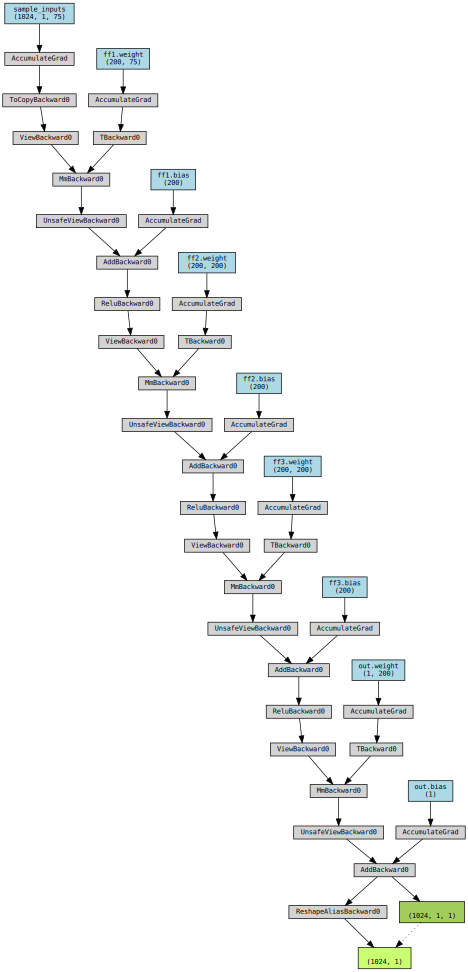

In [182]:
# Visualize model with torchviz
sample_inputs = next(iter(train_loader))[0].requires_grad_(True)
sample_y = model_ff(sample_inputs.to(device))
make_dot(sample_y, params=dict(list(model_ff.named_parameters())+[('sample_inputs', sample_inputs)]))

In [ ]:
summary(model_ff, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            --                        --
├─Linear: 1-1                            [1024, 200]               15,200
├─Linear: 1-2                            [1024, 200]               40,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (M): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

### TODO#4

Explain why the first linear layer has number of parameters = 15200

**Ans:**

75*200 + 200 where 75 is numbers of input and 200 is number of first layer neural, plus more 200 which is bias of 200 neural

# Training

In [ ]:
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

wandb: Currently logged in as: grniss (use `wandb login --relogin` to force relogin)


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9278
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6584
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9199
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6578
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9205
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6588
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9205
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6580
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9205
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6581
Training epoch 6...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9195
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6580
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9199
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6580
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9197
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6574
Saving new best model..
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9196
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6580
Training epoch 10...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9197
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6580



lr,█████▁▁▁▁▁
train_loss,█▁▂▂▂▁▁▁▁▁
val_loss,▆▃█▄▅▄▄▁▄▄
lr,0.002
train_loss,1.91972
val_loss,1.65796


Finished Training


### TODO#5

Plot loss and val_loss as a function of epochs.

In [ ]:
from matplotlib import pyplot as plt

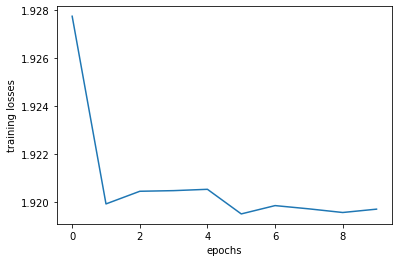

In [ ]:
plt.plot(range(10), train_losses)
plt.xlabel("epochs")
plt.ylabel("training losses")
plt.show()

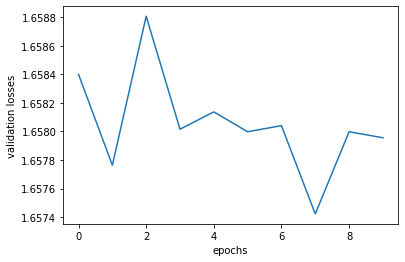

In [ ]:
plt.plot(range(10), val_losses)
plt.xlabel("epochs")
plt.ylabel("validation losses")
plt.show()

### TODO#6

When does the model start to overfit?

**Ans:**

Epoch that training loss start to increase which is epoch 1

### TODO#7

Plot the learning rate as a function of the epochs.

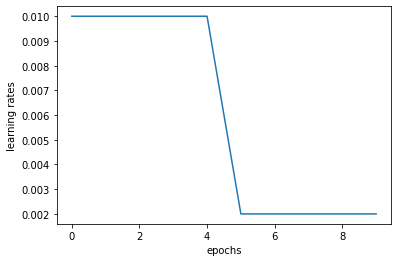

In [ ]:
plt.plot(range(10), learning_rates)
plt.xlabel("epochs")
plt.ylabel("learning rates")
plt.show()

### TODO#8

What makes the learning rate change?
(hint: try to understand the scheduler [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html))


**Ans:**

Loss is increase 3 times (epochs: 2, 3, 4) which is exceed our patient number which is 2

# Load Model

Use the code snippet below to load the model you just trained

In [ ]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")

Loaded epoch 7 model


# A more complex scheduling

The scheduler can be very complicated and you can write your own heuristic for it.

### TODO#9

Implement a custom learning rate scheduler that behaves like the following graph.

You might want to learn how to use [PyTorch's built-in learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) in order to build your own.

Learning rate should be function of epoch.

![](https://raw.githubusercontent.com/pjumruspun/ComProg2021-Workshop/main/graph.png)

In [28]:
# Implement scheduler here
class MyScheduler():
    def __init__(self, optimizer: torch.optim.Optimizer):
        self.optimizer = optimizer
        lr_list = [1, 4, 7, 10, 25/3, 20/3, 5, 10, 5.5, 1]
        ld_func = lambda epoch : lr_list[epoch % 9]
        self.lambda_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, ld_func)

    def step(self, epoch):
        # Changes the learning rate here
        self.lambda_scheduler.step()

In [29]:
# Now train with your scheduler
# my_scheduler = MyScheduler(...)
my_optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
my_scheduler = MyScheduler(my_optimizer)

In [30]:
for epoch in range(9):
  my_optimizer.step()
  my_scheduler.step(epoch)
  print(my_optimizer.param_groups[0]['lr'])
  

0.04
0.07
0.1
0.08333333333333334
0.06666666666666667
0.05
0.1
0.055
0.01


# [Optional] Wandb #

You should now have a project in wandb with the name `precipitation-nowcasting`, which you should see the latest run you just finished inside the project. If you look into the run, you should be able to see plots of learning rate, train loss, val loss in the `Charts` section. Below it should be `Gradients` and `Parameters` section.

# Wandb Observation #

### Optional TODO#1 

Write your own interpretation of the logs from this example. A simple sentence or two for each section is sufficient.

**Your answer:** 

# Evaluation

In [46]:
################################################################################
# TODO#10:                                                                     #
# Write a function to evaluate your model. Your function must predicts         #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: Read how to use PyTorch's MSE Loss                                     #
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here
    wandb.init(mode="disabled")
    acc = 0
    for i, (x, y) in enumerate(tqdm(data_loader)):
      x = x.to(device)
      y = y.to(device)
      predict = model(x)
      loss = loss_fn(predict, y)
      acc += loss
    mse = acc/(i+1)
    return mse

In [ ]:
# We will use majority rule as a baseline.
def majority_baseline(label_set):
    unique, counts = np.unique(label_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    label_set = label_set.reshape(-1,1)
    for r in label_set:
        baseline += (majority - r) ** 2 / len(label_set)
    return baseline

In [ ]:
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))

baseline
train [1.94397725]
validate [1.6746546]


In [ ]:
print('FF-model')
print('train', evaluate(train_loader, model_ff).item())
print('validate', evaluate(val_loader, model_ff).item())

FF-model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.919380784034729


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.6576783657073975


# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

To access PyTorch's dropout, use `nn.Dropout`. Read more about PyTorch's built-in Dropout layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [96]:
################################################################################
# TODO#11:                                                                     #
# Write a feedforward model with dropout                                       #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class FeedForwardNN_Dropout(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN_Dropout, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = self.dropout(F.relu(self.ff2(hd1)))
        y = self.dropout(F.relu(self.ff3(hd2)))
        y = self.out(y)
        return y.reshape(-1, 1)

# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff_dropout = FeedForwardNN_Dropout(hidden_size=config['hidden_size'])
model_ff_dropout = model_ff.to(device)
optimizer_dropout = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler_dropout = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)


In [97]:
################################################################################
# TODO#12:                                                                     #
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

train_losses_dropout = []
val_losses_dropout = []
learning_rates_dropout = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-dropout',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff_dropout, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_losses_dropout = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates_dropout.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff_dropout.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff_dropout(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_losses_dropout.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses_dropout.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_ff_dropout.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_ff_dropout(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses_dropout.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses_dropout[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff_dropout.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_ff_dropout.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')


start training ff dropout


Training epoch 1...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9073
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6612
Saving new best model..
Training epoch 2...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9073
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6612
Training epoch 3...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9073
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6612
Training epoch 4...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9073
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6612
Training epoch 5...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9073
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6612
Training epoch 6...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9073
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6612
Training epoch 7...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9073
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6612
Training epoch 8...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9073
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6612
Training epoch 9...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9073
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6612
Training epoch 10...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9073
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6612



lr,████▂▂▂▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
lr,0.0001
train_loss,1.90733
val_loss,1.66122


Finished Training


### TODO#13

Plot the losses and MSE of the training and validation as before. Evaluate the dropout model's performance

In [37]:
from matplotlib import pyplot as plt

In [ ]:
# Plot here
plt.plot(range(10), train_losses_dropout)
plt.xlabel("epochs")
plt.ylabel("training losses")
plt.show()

plt.plot(range(10), val_losses_dropout)
plt.xlabel("epochs")
plt.ylabel("validation losses")
plt.show()

In [ ]:
# Evaluate
print('FF-model_dropout')
print('train', evaluate(train_loader, model_ff_dropout).item())
print('validate', evaluate(val_loader, model_ff_dropout).item())

# Convolution Neural Networks
Now let's try to incorporate the grid sturcture to your model. Instead of passing in vectors, we are going to pass in the 5x5 grid into the model (5lat x 5long x 3channel). You are going to implement you own 2d-convolution neural networks with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Conv2DNN                                 --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
==========================================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read PyTorch documentation to see the list of available layers and options you can use.                         

In [52]:
################################################################################
# TODO#14:                                                                     #
# Complete the code for preparing data for training CNN                        #
# Input for CNN should not have time step.                                     #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def preprocess_for_cnn(x_train, y_train, x_val, y_val):
    x_train_cnn = x_train.reshape((-1, 5, 5, 3)).transpose((0,3,1,2))
    y_train_cnn = y_train.reshape((-1, 1))
    x_val_cnn = x_val.reshape((-1, 5, 5, 3)).transpose((0,3,1,2))
    y_val_cnn = y_val.reshape((-1, 1))
    x_test_cnn = x_test.reshape((-1, 5, 5, 3)).transpose((0,3,1,2))
    y_test_cnn = y_test.reshape((-1, 1))

    return x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn

x_train_cnn, y_train_cnn, x_val_cnn, y_val_cnn, x_test_cnn, y_test_cnn = preprocess_for_cnn(x_train, y_train, x_val, y_val)

def normalizer_std_cnn(X):
    X_tmp = X.transpose((1, 0, 2, 3)).reshape(3, -1)
    count = X_tmp.shape[0]
    scaler = preprocessing.StandardScaler().fit(X.reshape(-1, 1))
    return scaler

normalizer = normalizer_std_cnn(x_train_cnn)

class RainfallDatasetCNN(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        normalizer = self.normalizer
        x = normalizer.transform(x.reshape(-1,1)).reshape(x.shape)
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]
    

train_dataset_cnn = RainfallDatasetCNN(x_train_cnn, y_train_cnn, normalizer)
val_dataset_cnn = RainfallDatasetCNN(x_val_cnn, y_val_cnn, normalizer)
test_dataset_cnn = RainfallDatasetCNN(x_test_cnn, y_test_cnn, normalizer)

train_loader = DataLoader(train_dataset_cnn, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)

(1147740, 3, 5, 5)
(1147740, 1)
(464195, 3, 5, 5)
(464195, 1)
(558575, 3, 5, 5)
(558575, 1)


In [41]:
################################################################################
# TODO#15:                                                                     #
# Write a PyTorch convolutional neural network model.                          #
# You might want to use the layer torch.flatten somewhere                      #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class FeedForwardCNN(nn.Module):
    def __init__(self, hidden_size=200, kernel_size=3):
        super(FeedForwardCNN, self).__init__()
        self.conv2d = nn.Conv2d(3, hidden_size, kernel_size)
        self.ff1 = nn.Linear(hidden_size * (kernel_size * kernel_size), hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.conv2d(x))
        hd1 = torch.flatten(hd1, 1)
        hd2 = F.relu(self.ff1(hd1))
        hd3 = F.relu(self.ff2(hd2))
        y = self.out(hd3)
        return y.reshape(-1, 1)

In [42]:
config = {
    'architecture': 'feedforward_cnn',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

model_cnn = FeedForwardCNN(hidden_size=config['hidden_size'])
model_cnn = model_cnn.to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

In [43]:
################################################################################
# TODO#16:                                                                     #
# Complete the code to train your cnn model                                    #
################################################################################
print('start training conv2d')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
train_losses_cnn = []
val_losses_cnn = []
learning_rates_cnn = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-cnn',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_cnn, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates_cnn.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_cnn.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_cnn(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses_cnn.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_cnn.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_cnn(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses_cnn.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses_cnn[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_cnn.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, '/content/gdrive/My Drive/model_cnn.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training conv2d


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 2.1351
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9222
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6588
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9204
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6607
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9204
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6575
Saving new best model..
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9204
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6582
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9204
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6584
Training epoch 7...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9200
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6580
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9188
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6573
Saving new best model..
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9185
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6564
Saving new best model..
Training epoch 10...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9187
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6576



lr,███████▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,█▅█▃▄▄▄▂▁▃
lr,0.002
train_loss,1.91873
val_loss,1.65762


Finished Training


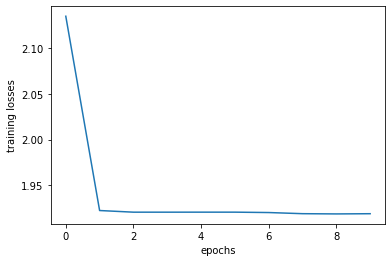

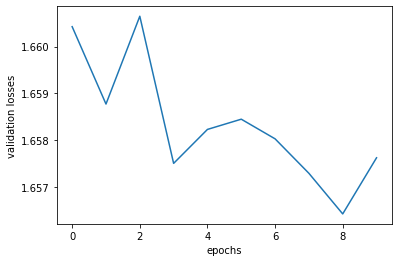

In [44]:
# Plot losses
plt.plot(range(10), train_losses_cnn)
plt.xlabel("epochs")
plt.ylabel("training losses")
plt.show()

plt.plot(range(10), val_losses_cnn)
plt.xlabel("epochs")
plt.ylabel("validation losses")
plt.show()

In [49]:
# Evaluate
print('FF-model_dropout')
print('train', evaluate(train_loader, model_cnn).item())
print('validate', evaluate(val_loader, model_cnn).item())

FF-model_dropout


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9184720516204834


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.6576204299926758


# Gated Recurrent Units

Now, you want to add time steps into your model. Recall the original data has 5 time steps per item. You are going to pass in a data of the form 5 timesteps x 75data. This can be done using a GRU layer. Implement you own GRU network with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
GRUModel                                 --                        --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
==========================================================================================
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
```


These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         
The result should be better than the feedforward model and at least on par with your CNN model.    

Do consult PyTorch documentation on how to use [GRUs](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).


In [186]:
################################################################################
# TODO#17:                                                                     #
# Complete the code for preparing data for training GRU                        #
# GRU's input should has 3 dimensions.                                         #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def preprocess_for_gru(x_train, y_train, x_val, y_val):

    x_train_gru = x_train.reshape((-1, 5, 75))
    y_train_gru = y_train.reshape((-1, 5))
    x_val_gru = x_val.reshape((-1, 5, 75))
    y_val_gru = y_val.reshape((-1, 5))
    x_test_gru = x_test.reshape((-1, 5, 75))
    y_test_gru = y_test.reshape((-1, 5))

    return x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru

x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru = preprocess_for_gru(x_train, y_train, x_val, y_val)
print(x_train_gru.shape, y_train_gru.shape)
print(x_val_gru.shape, y_val_gru.shape)
print(x_test_gru.shape, y_test_gru.shape)

def normalizer_std_gru(X):
    scaler = preprocessing.StandardScaler().fit(X.reshape(-1, 1))
    return scaler

normalizer = normalizer_std_gru(x_train_gru)

class RainfallDatasetGRU(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        normailzer = self.normalizer
        x = normalizer.transform(x.flatten().reshape(-1, 1)).reshape(x.shape)
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]
    

train_dataset_gru = RainfallDatasetGRU(x_train_gru, y_train_gru, normalizer)
val_dataset_gru = RainfallDatasetGRU(x_val_gru, y_val_gru, normalizer)
test_dataset_gru = RainfallDatasetGRU(x_test_gru, y_test_gru, normalizer)

train_loader = DataLoader(train_dataset_gru, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)

(229548, 5, 75) (229548, 5)
(92839, 5, 75) (92839, 5)
(111715, 5, 75) (111715, 5)
(229548, 5, 75)
(229548, 5)
(92839, 5, 75)
(92839, 5)
(111715, 5, 75)
(111715, 5)


In [77]:
################################################################################
# TODO#18                                                                      #
# Write a PyTorch gru model.                                                   #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class FeedForwardGRU(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardGRU, self).__init__()
        self.gru = nn.GRU(75, hidden_size, batch_first=True)
        self.ff1 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1, _ = self.gru(x)
        hd1 = F.relu(self.ff1(hd1))
        y = self.out(hd1)
        return y.reshape(-1, 5)

config = {
    'architecture': 'GRU',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10,
}

# Model
model_gru = FeedForwardGRU(hidden_size=config['hidden_size'])
model_gru = model_gru.to(device)
optimizer = torch.optim.Adam(model_gru.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

In [81]:
################################################################################
# TODO#19                                                                      #
# Complete the code to train your gru model                                    #
################################################################################
print('start training gru')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
train_losses_gru = []
val_losses_gru = []
learning_rates_gru = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-gru',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_gru, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates_gru.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_gru.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_gru(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses_gru.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_gru.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_gru(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses_gru.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses_gru[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_gru.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state,'/content/gdrive/My Drive/model_gru.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training gru


Training epoch 1...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9110
Validating epoch 1


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6729
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9091
Validating epoch 2


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6714
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9078
Validating epoch 3


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6705
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9150
Validating epoch 4


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6707
Training epoch 5...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9097
Validating epoch 5


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6691
Saving new best model..
Training epoch 6...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9159
Validating epoch 6


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6724
Training epoch 7...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9075
Validating epoch 7


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6710
Training epoch 8...
Current LR: 0.01


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9261
Validating epoch 8


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6718
Training epoch 9...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9096
Validating epoch 9


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6692
Training epoch 10...
Current LR: 0.002


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9073
Validating epoch 10


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6681
Saving new best model..



lr,████████▁▁
train_loss,▂▂▁▄▂▄▁█▂▁
val_loss,█▆▄▅▂▇▅▆▃▁
lr,0.002
train_loss,1.90733
val_loss,1.66812


Finished Training


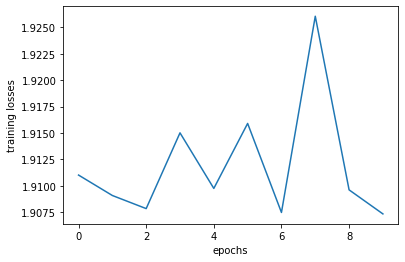

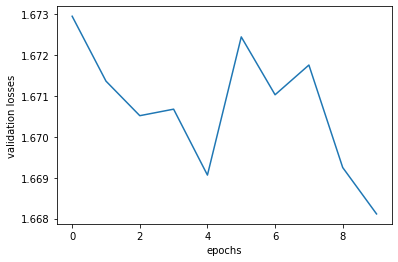

In [86]:
# Plot
plt.plot(range(10), train_losses_gru)
plt.xlabel("epochs")
plt.ylabel("training losses")
plt.show()

plt.plot(range(10), val_losses_gru)
plt.xlabel("epochs")
plt.ylabel("validation losses")
plt.show()

In [87]:
# Evaluate
print('GRU-model_dropout')
print('train', evaluate(train_loader, model_gru).item())
print('validate', evaluate(val_loader, model_gru).item())

GRU-model_dropout


  0%|          | 0/225 [00:00<?, ?it/s]

train 1.9055248498916626


  0%|          | 0/91 [00:00<?, ?it/s]

validate 1.6681151390075684


# Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find printing computation graphs helpful in debugging complicated models.    
Your model should be better than your CNN or GRU model in the previous sections.

Some ideas:

- Tune the hyperparameters
- Adding dropouts
- Combining CNN with GRUs

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [191]:
# Prep data as you see fit
normalizer = normalizer_std_cnn(x_train_cnn)

train_dataset_cnn = RainfallDatasetCNN(x_train_cnn, y_train_cnn, normalizer)
val_dataset_cnn = RainfallDatasetCNN(x_val_cnn, y_val_cnn, normalizer)
test_dataset_cnn = RainfallDatasetCNN(x_test_cnn, y_test_cnn, normalizer)

train_loader = DataLoader(train_dataset_cnn, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)

(1147740, 3, 5, 5)
(1147740, 1)
(464195, 3, 5, 5)
(464195, 1)
(558575, 3, 5, 5)
(558575, 1)


In [196]:
################################################################################
# TODO#20                                                                      #
# Write a function that returns your best PyTorch model. You can use anything  #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class CNN_GRU(nn.Module):
    def __init__(self, hidden_size=200, kernel_size=3):
        super(CNN_GRU, self).__init__()
        self.conv2d = nn.Conv2d(3, hidden_size, kernel_size)
        self.batchnorm2d = nn.BatchNorm2d(hidden_size)
        self.maxpool2d = nn.MaxPool2d(kernel_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.ff = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # hidden_size * (kernel_size * kernel_size) * hidden_size
        cv1 = (self.dropout(self.conv2d(x)))
        mp1 = F.relu(self.maxpool2d(cv1))
        t = mp1.reshape(-1 , 200, 1 ** 2)
        t = t.permute(0,2,1)
        ff_prep, _ = self.gru(t)
        hd1 = F.relu(self.dropout(self.ff(ff_prep)))
        y = self.out(hd1)
        return y.reshape(-1, 1)

config = {
    'lr': 0.008,
    'hidden_size': 200,
    'scheduler_factor': 0.4,
    'scheduler_patience': 1,
    'scheduler_min_lr': 1e-4,
    'epochs': 5,
}

# Model
best_model = CNN_GRU(hidden_size=config['hidden_size'])
best_model = best_model.to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

In [198]:
################################################################################
# TODO#21                                                                      #
# Complete the code to train your best model                                   #
################################################################################
print('start training the best model')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
train_losses_best_model = []
val_losses_best_model = []
learning_rates_best_model = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-best-model',
    config=config,
)

# Log parameters and gradients
wandb.watch(best_model, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates_best_model.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    best_model.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = best_model(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses_best_model.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    best_model.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = best_model(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses_best_model.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses_best_model[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': best_model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state,'/content/gdrive/My Drive/best_model.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training the best model


Training epoch 1...
Current LR: 0.0032


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9187
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6602
Saving new best model..
Training epoch 2...
Current LR: 0.0032


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9184
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6601
Saving new best model..
Training epoch 3...
Current LR: 0.00128


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9185
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6583
Saving new best model..
Training epoch 4...
Current LR: 0.00128


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9183
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6593
Training epoch 5...
Current LR: 0.0005120000000000001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9179
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6594



lr,██▃▃▁
train_loss,█▅▇▄▁
val_loss,██▁▅▅
lr,0.00051
train_loss,1.91794
val_loss,1.65945


Finished Training


In [199]:
  # Evaluate best model on validation and test set
print('val', evaluate(val_loader, best_model).item())
print('test', evaluate(test_loader, best_model).item())

  0%|          | 0/454 [00:00<?, ?it/s]

val 1.6594479084014893


  0%|          | 0/546 [00:00<?, ?it/s]

test 1.1663196086883545


In [185]:
# Also evaluate your fully-connected model and CNN/GRU model on the test set.
normalizer = normalizer_std(x_train_ff)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)
print('ff', evaluate(train_loader, model_ff).item())
print('ff dropout', evaluate(train_loader, model_ff_dropout).item())

test_loader = DataLoader(test_dataset_cnn, batch_size=1024, shuffle=False, pin_memory=True)
print('cnn', evaluate(test_loader, model_cnn).item())

(558575, 75)
(558575, 1)


  0%|          | 0/1121 [00:00<?, ?it/s]

ff 1.9594753980636597


  0%|          | 0/1121 [00:00<?, ?it/s]

ff dropout 1.9232709407806396


  0%|          | 0/546 [00:00<?, ?it/s]

cnn 1.163036584854126


In [187]:
test_loader = DataLoader(test_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)
print('gru', evaluate(train_loader, model_gru).item())

  0%|          | 0/225 [00:00<?, ?it/s]

gru 1.9085725545883179


To get full credit for this part, your best model should be better than the previous models on the **test set**. 

### TODO#22

Explain what helped and what did not help here

**Ans:**

Help: following this one https://www.researchgate.net/figure/Overview-of-the-CNN-LSTM-and-CNN-GRU-hybrid-model-architecture_fig3_349537101 I tried to combine CNN with GRU but I think 2 conv2d maybe not fit my dataset so I reduce it to one time

Not help: try to tune parameter myself, and then change to current method and it on.

# [Optional] Augmentation using data loader

### Optional TODO#2

Implement a new dataloader on your best model that will perform data augmentation. Try adding noise of zero mean and variance of $10e^{-2}$.

Then, train your model.

In [ ]:
# Write Dataset/DataLoader with noise here


In [ ]:
print('start training the best model with noise')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
# Evaluate the best model trained with noise on validation and test set
